In [1]:
import asyncio
from pathlib import Path
from shutil import copy, move

import nest_asyncio
import nibabel as nb
import nitransforms as nt
import numpy as np
from nipreps.synthstrip.wrappers.nipype import SynthStrip
from nipype.interfaces.afni import Volreg
from scipy.ndimage import binary_dilation
from skimage.morphology import ball

from eddymotion.registration import ants as erants

nest_asyncio.apply()

In [2]:
DATA_PATH = Path("/data/datasets/")
WORKDIR = Path.home() / "tmp" / "eddymotiondev" / "ismrm25"
WORKDIR.mkdir(parents=True, exist_ok=True)

OUTPUT_DIR = Path("/data/derivatives") / "eddymotion-ismrm25-exp2"
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [3]:
bold_runs = [
    Path(line)
    for line in (DATA_PATH / "ismrm_sample.txt").read_text().splitlines()
    if line.strip()
]

In [4]:
results = []
for bold_run in bold_runs:
    avg_path = OUTPUT_DIR / bold_run.parent / f"{bold_run.name.rsplit('_', 1)[0]}_boldref.nii.gz"

    if not avg_path.exists():
        nii = nb.load(DATA_PATH / bold_run)
        average = nii.get_fdata().mean(-1)
        avg_path.parent.mkdir(exist_ok=True, parents=True)
        nii.__class__(average, nii.affine, nii.header).to_filename(avg_path)

    bmask_path = (
        OUTPUT_DIR / bold_run.parent / f"{bold_run.name.rsplit('_', 1)[0]}_label-brain_mask.nii.gz"
    )
    if not bmask_path.exists():
        bmsk_results = SynthStrip(
            in_file=str(avg_path),
            use_gpu=True,
        ).run(cwd=str(WORKDIR))
        copy(bmsk_results.outputs.out_mask, bmask_path)

    dilmask_path = (
        avg_path.parent / f"{avg_path.name.rsplit('_', 1)[0]}_label-braindilated_mask.nii.gz"
    )

    if not dilmask_path.exists():
        niimsk = nb.load(bmask_path)
        niimsk.__class__(
            binary_dilation(niimsk.get_fdata() > 0.0, ball(4)).astype("uint8"),
            niimsk.affine,
            niimsk.header,
        ).to_filename(dilmask_path)

    oned_matrix_path = avg_path.parent / f"{avg_path.name.rsplit('_', 1)[0]}_desc-hmc_xfm.txt"
    realign_output = (
        avg_path.parent / f"{avg_path.name.rsplit('_', 1)[0]}_desc-realigned_bold.nii.gz"
    )

    if not realign_output.exists():
        volreg_results = Volreg(
            in_file=str(DATA_PATH / bold_run),
            in_weight_volume=str(dilmask_path),
            args="-Fourier -twopass",
            zpad=4,
            outputtype="NIFTI_GZ",
            oned_matrix_save=f"{oned_matrix_path}.aff12.1D",
            out_file=str(realign_output),
            num_threads=12,
        ).run(cwd=str(WORKDIR))

        move(volreg_results.outputs.oned_matrix_save, oned_matrix_path)

In [4]:
afni_realigned = [
    OUTPUT_DIR / bold_run.parent / f"{bold_run.name.rsplit('_', 1)[0]}_desc-realigned_bold.nii.gz"
    for bold_run in bold_runs
]

In [5]:
afni_realigned

[PosixPath('/data/derivatives/eddymotion-ismrm25-exp2/ds000005/sub-01/func/sub-01_task-mixedgamblestask_run-03_desc-realigned_bold.nii.gz'),
 PosixPath('/data/derivatives/eddymotion-ismrm25-exp2/ds000005/sub-02/func/sub-02_task-mixedgamblestask_run-01_desc-realigned_bold.nii.gz'),
 PosixPath('/data/derivatives/eddymotion-ismrm25-exp2/ds000005/sub-06/func/sub-06_task-mixedgamblestask_run-02_desc-realigned_bold.nii.gz'),
 PosixPath('/data/derivatives/eddymotion-ismrm25-exp2/ds000005/sub-15/func/sub-15_task-mixedgamblestask_run-03_desc-realigned_bold.nii.gz'),
 PosixPath('/data/derivatives/eddymotion-ismrm25-exp2/ds000005/sub-14/func/sub-14_task-mixedgamblestask_run-01_desc-realigned_bold.nii.gz'),
 PosixPath('/data/derivatives/eddymotion-ismrm25-exp2/ds000030/sub-10570/func/sub-10570_task-bht_desc-realigned_bold.nii.gz'),
 PosixPath('/data/derivatives/eddymotion-ismrm25-exp2/ds000030/sub-10460/func/sub-10460_task-scap_desc-realigned_bold.nii.gz'),
 PosixPath('/data/derivatives/eddymotion

In [6]:
from matplotlib import pyplot as plt

In [43]:
def plot_profile(image_path, axis=None, indexing=None, cmap="gray", label=None, figsize=(15, 1.7)):
    """Plots a single image slice on a given axis or a new figure if axis is None."""
    # Load the image
    image_data = nb.load(image_path).get_fdata()

    # Define default indexing if not provided
    if indexing is None:
        indexing = (
            image_data.shape[0] // 2,
            3 * image_data.shape[1] // 4,
            slice(None),
            slice(None),
        )

    # If no axis is provided, create a new figure and axis
    if axis is None:
        fig, axis = plt.subplots(figsize=figsize)
    else:
        fig = None  # If axis is provided, we won't manage the figure

    # Display the image on the specified axis with aspect='auto' and the colormap
    axis.imshow(image_data[indexing], aspect="auto", cmap=cmap)

    # Turn off the axis for a cleaner look
    axis.axis("off")

    if label:
        # Annotate the plot with the provided label
        axis.text(
            0.02,
            0.95,
            label,
            color="white",
            fontsize=12,
            ha="left",
            va="top",
            transform=axis.transAxes,
        )

    # If we created the figure, show it
    if fig is not None:
        plt.show()

    return fig


# def plot_combined_profile(images, indexing=None, figsize=(15, 1.7), cmap='gray', labels=None):
#     # Create a figure with three subplots in a vertical layout and specified figure size
#     n_images = len(images)

#     nplots = n_images * len(indexing or [True])
#     figsize = (figsize[0], figsize[1] * nplots)
#     fig, axes = plt.subplots(nplots, 1, figsize=figsize, constrained_layout=True)

#     if labels is None or isinstance(labels, str):
#         labels = (labels, ) * nplots

#     if indexing is None or len(indexing) == 0:
#         indexing = [None]

#     for i, idx in enumerate(indexing):
#         for j in range(len(images)):
#             ax = axes[i * n_images + j]
#             plot_profile(images[j], axis=ax, indexing=idx, cmap=cmap, label=labels[j])

#     return fig


def plot_combined_profile(
    images, afni_fd, eddymotion_fd, indexing=None, figsize=(15, 1.7), cmap="gray", labels=None
):
    # Calculate the number of profile plots
    n_images = len(images)
    nplots = n_images * len(indexing or [True])
    total_height = figsize[1] * nplots + 2  # Adjust figure height for FD plot

    # Create a figure with one extra row for the FD plot, setting `sharex=True` for shared x-axis
    fig, axes = plt.subplots(
        nplots + 1, 1, figsize=(figsize[0], total_height), constrained_layout=True, sharex=True
    )

    # Plot the framewise displacement on the first axis
    fd_axis = axes[0]
    timepoints = np.arange(len(afni_fd))  # Assuming afni_fd and eddymotion_fd have the same length
    fd_axis.plot(timepoints, afni_fd, label="AFNI 3dVolreg FD", color="blue")
    fd_axis.plot(timepoints, eddymotion_fd, label="eddymotion FD", color="orange")
    fd_axis.set_ylabel("FD (mm)")
    fd_axis.legend(loc="upper right")
    fd_axis.set_xticks([])  # Hide x-ticks to keep x-axis clean

    # Set labels for profile plots if not provided
    if labels is None or isinstance(labels, str):
        labels = (labels,) * nplots

    # Set indexing if not provided
    if indexing is None or len(indexing) == 0:
        indexing = [None]

    # Plot each profile slice below the FD plot
    for i, idx in enumerate(indexing):
        for j in range(len(images)):
            ax = axes[i * n_images + j + 1]  # Shift index by 1 to account for FD plot
            plot_profile(images[j], axis=ax, indexing=idx, cmap=cmap, label=labels[j])

    return fig

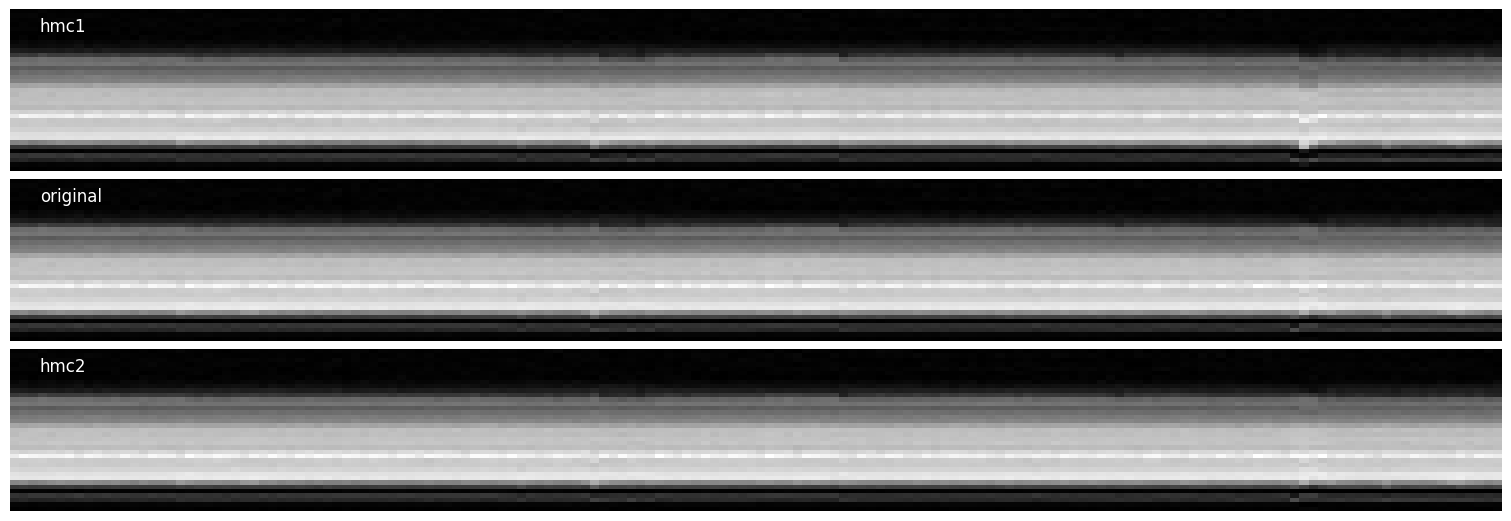

In [29]:
plot_combined_profile(
    (DATA_PATH / bold_runs[15], afni_realigned[15], afni_realigned[15]),
    labels=("hmc1", "original", "hmc2"),
);

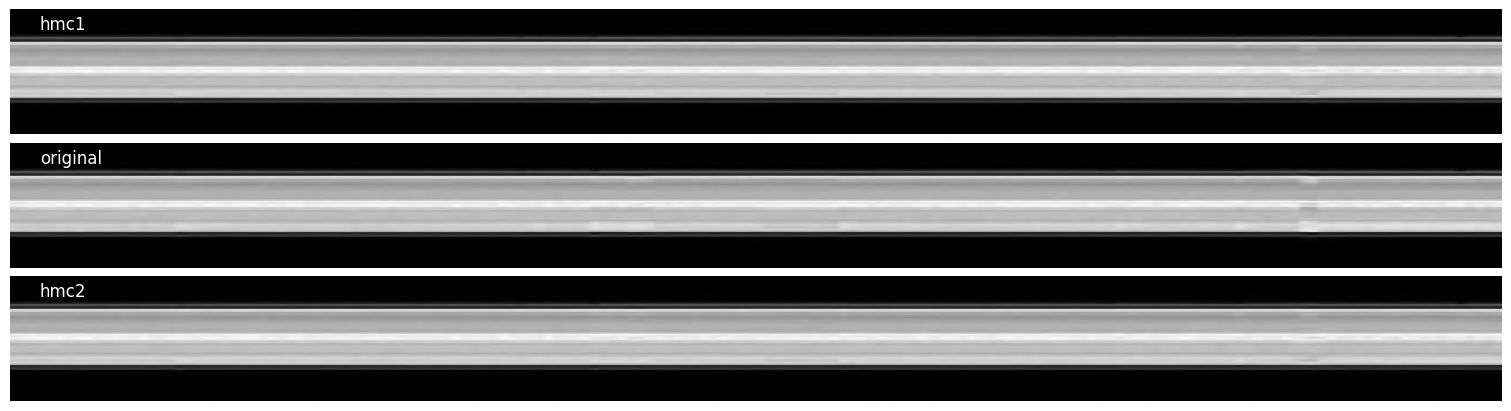

In [10]:
datashape = nb.load(DATA_PATH / bold_runs[15]).shape
plot_profile(
    DATA_PATH / bold_runs[15],
    afni_realigned[15],
    afni_realigned[15],
    indexing=(slice(None), 3 * datashape[1] // 4, datashape[2] // 2, slice(None)),
);

In [11]:
from eddymotion.model.base import AverageModel
from eddymotion.utils import random_iterator

In [12]:
async def ants(t, data, hdr, nii, brainmask_path, semaphore, workdir):
    async with semaphore:
        # Set up paths
        fixed_path = workdir / f"fixedimage_{t:04d}.nii.gz"
        moving_path = workdir / f"movingimage_{t:04d}.nii.gz"

        # Create a mask for the specific timepoint
        t_mask = np.zeros(data.shape[-1], dtype=bool)
        t_mask[t] = True

        # Fit and predict using the model
        model = AverageModel()
        model.fit(
            data[..., ~t_mask],
            stat="median",
        )
        fixed_data = model.predict()

        # Save fixed and moving images
        nii.__class__(fixed_data, nii.affine, hdr).to_filename(fixed_path)
        nii.__class__(data[..., t_mask], nii.affine, hdr).to_filename(moving_path)

        # Generate the command
        cmdline = erants.generate_command(
            fixed_path,
            moving_path,
            fixedmask_path=brainmask_path,
            output_transform_prefix=f"conversion-{t:02d}",
            num_threads=8,
        )

        # Run the command
        proc = await asyncio.create_subprocess_shell(
            cmdline,
            cwd=str(workdir),
            stdout=(workdir / f"ants-{t:04d}.out").open("w+"),
            stderr=(workdir / f"ants-{t:04d}.err").open("w+"),
        )
        returncode = await proc.wait()
        return returncode

In [29]:
# Set up concurrency limit and tasks
semaphore = asyncio.Semaphore(12)
tasks = []

# Load and preprocess data
for bold_run in bold_runs:
    print(bold_run.parent)
    workdir = WORKDIR / bold_run.parent
    workdir.mkdir(parents=True, exist_ok=True)
    data_path = DATA_PATH / bold_run
    brainmask_path = (
        OUTPUT_DIR / bold_run.parent / f"{bold_run.name.rsplit('_', 1)[0]}_label-brain_mask.nii.gz"
    )

    nii = nb.load(data_path)
    hdr = nii.header.copy()
    hdr.set_sform(nii.affine, code=1)
    hdr.set_qform(nii.affine, code=1)
    data = nii.get_fdata(dtype="float32")
    n_timepoints = data.shape[-1]

    # Start tasks immediately upon creation
    for t in random_iterator(n_timepoints):  # Random iterator
        task = asyncio.create_task(ants(t, data, hdr, nii, brainmask_path, semaphore, workdir))
        tasks.append(task)

# Await all tasks
results = await asyncio.gather(*tasks, return_exceptions=True)

ds000005/sub-01/func
ds000005/sub-02/func
ds000005/sub-06/func
ds000005/sub-15/func
ds000005/sub-14/func
ds000030/sub-10570/func
ds000030/sub-10460/func
ds000030/sub-10304/func
ds000030/sub-10376/func
ds000030/sub-11097/func
ds000210/sub-28/func
ds000210/sub-16/func
ds000210/sub-24/func
ds000210/sub-18/func
ds000210/sub-09/func
ds002785/sub-0202/func
ds002785/sub-0214/func
ds002785/sub-0139/func
ds002785/sub-0178/func
ds002785/sub-0016/func


CancelledError: 

In [39]:
from nitransforms.resampling import apply

from eddymotion.registration.utils import displacement_framewise

afni_fd = {}
nitransforms_fd = {}
# Load and preprocess data
for bold_run in bold_runs:
    work_path = WORKDIR / bold_run.parent

    n_timepoints = len(list(work_path.glob("*.mat")))

    xfms = [
        nt.linear.Affine(
            nt.io.itk.ITKLinearTransform.from_filename(
                work_path / f"conversion-{t:02d}0GenericAffine.mat"
            ).to_ras(
                reference=work_path / f"fixedimage_{t:04d}.nii.gz",
                moving=work_path / f"movingimage_{t:04d}.nii.gz",
            )
        )
        for t in range(n_timepoints)
    ]

    nii = nb.load(DATA_PATH / bold_run)
    nitransforms_fd[str(bold_run)] = np.array([displacement_framewise(nii, xfm) for xfm in xfms])

    hmc_xfm = nt.linear.LinearTransformsMapping(xfms)
    out_nitransforms = (
        OUTPUT_DIR
        / bold_run.parent
        / f"{bold_run.name.rsplit('_', 1)[0]}_desc-nitransforms_bold.nii.gz"
    )
    if not out_nitransforms.exists():
        apply(
            hmc_xfm,
            spatialimage=nii,
            reference=nii,
        ).to_filename(out_nitransforms)

    afni_xfms = nt.linear.load(
        OUTPUT_DIR / bold_run.parent / f"{bold_run.name.rsplit('_', 1)[0]}_desc-hmc_xfm.txt"
    )
    afni_fd[str(bold_run)] = np.array(
        [displacement_framewise(nii, afni_xfms[i]) for i in range(len(afni_xfms))]
    )

    out_afni = (
        OUTPUT_DIR / bold_run.parent / f"{bold_run.name.rsplit('_', 1)[0]}_desc-afni_bold.nii.gz"
    )
    if not out_afni.exists():
        apply(
            afni_xfms,
            spatialimage=nii,
            reference=nii,
        ).to_filename(out_afni)

In [40]:
afni_fd

{'ds000005/sub-01/func/sub-01_task-mixedgamblestask_run-03_bold.nii.gz': array([0.        , 0.10793175, 0.07858656, 0.18502728, 0.12220535,
        0.168716  , 0.14503799, 0.14865804, 0.1803173 , 0.13340028,
        0.21312989, 0.14758936, 0.21596067, 0.17506483, 0.20782903,
        0.15595841, 0.20194838, 0.15876696, 0.20505382, 0.17766943,
        0.22369231, 0.18314188, 0.21592902, 0.17853583, 0.229064  ,
        0.19048681, 0.24726324, 0.21111294, 0.24701978, 0.20154606,
        0.24295423, 0.20993123, 0.25803219, 0.25123738, 0.27384459,
        0.25426043, 0.25935159, 0.27905261, 0.27254138, 0.3148201 ,
        0.2813835 , 0.27881108, 0.25465829, 0.29885062, 0.27027669,
        0.29357876, 0.26970242, 0.2988554 , 0.24956041, 0.30005082,
        0.24795282, 0.29294854, 0.23768819, 0.30652736, 0.24880974,
        0.29505102, 0.23742751, 0.30218212, 0.24163347, 0.29045177,
        0.24481863, 0.26511888, 0.24801033, 0.25128672, 0.24696843,
        0.25947232, 0.254379  , 0.26095674, 

In [44]:
# Generate an index.html with links to each SVG file
index_path = OUTPUT_DIR / "index.html"
with open(index_path, "w") as index_file:
    index_file.write("<html><body>\n")
    index_file.write("<h1>Profile Plot Index</h1>\n<ul>\n")

    for bold_run in bold_runs:
        original = DATA_PATH / bold_run
        nitransforms = (
            OUTPUT_DIR
            / bold_run.parent
            / f"{bold_run.name.rsplit('_', 1)[0]}_desc-nitransforms_bold.nii.gz"
        )
        afni = (
            OUTPUT_DIR
            / bold_run.parent
            / f"{bold_run.name.rsplit('_', 1)[0]}_desc-realigned_bold.nii.gz"
        )

        datashape = nb.load(original).shape

        fig = plot_combined_profile(
            (afni, original, nitransforms),
            afni_fd[str(bold_run)],
            nitransforms_fd[str(bold_run)],
            labels=("3dVolreg", str(bold_run), "eddymotion"),
            indexing=(None, (slice(None), 3 * datashape[1] // 4, datashape[2] // 2, slice(None))),
        )

        # Save the figure
        out_svg = OUTPUT_DIR / bold_run.parent / bold_run.name.replace(".nii.gz", ".svg")
        fig.savefig(out_svg, format="svg")
        fig.savefig(out_svg.with_suffix(".png"), format="png", dpi=320)
        plt.close(fig)

        index_file.write(f"<li><a href={out_svg.relative_to(OUTPUT_DIR)}>{bold_run}</a></li>\n")

    index_file.write("</ul>\n</body></html>")